In [1]:
import pandas
import os
import matplotlib.pyplot as plt

data_path = 'perf-data'
devices = ['3b+', '3b.']
osses = ["ubuntu64", "rpios32"]
runtimes = ['go', 'js', 'py','native']

In [2]:
flat_files = []
iterations = os.listdir(data_path)

for it in iterations:
    it_files = os.listdir(f"{data_path}/{it}")
    for it_file in it_files:
        flat_files.append(f"{data_path}/{it}/{it_file}")

In [3]:
def pretty_print_data(data, unit='ns'):
    for device in data.keys():
        print(f"{device}:")
        for os in data[device].keys():
            print(f'\t{os}:')
            for runtime in data[device][os].keys():
                converted_data = data[device][os][runtime]
                if converted_data is None:                    
                    continue
                if unit == 'µs':
                    converted_data = converted_data / 1000
                if unit == 'ms':
                    converted_data = converted_data / 1000000
                if unit == 's':
                    converted_data = converted_data / 1000000000
                if unit == '%':
                    converted_data = converted_data * 100
                print(f"\t\t{runtime}: {converted_data} {unit}")

In [4]:
runtime_device_files_total = {}
for device in devices:
    runtime_device_files_total[device] = {}
    device_files = list(filter(lambda file: device in file, flat_files))
    for os in osses:
        runtime_device_files_total[device][os] = {}
        device_os_files = list(filter(lambda file: os in file, device_files))
        for runtime in runtimes:
            runtime_device_files = list(filter(lambda file: runtime in file, device_os_files)) 
            if len(runtime_device_files) <= 0:
                continue
            runtime_device_files_total[device][os][runtime] = runtime_device_files

In [5]:
def getConcatData(files):    
    runtime_data = pandas.DataFrame()
    for file in files:
        data = pandas.read_csv(file)
        runtime_data = runtime_data.append(data, ignore_index=True)
    return runtime_data

runtime_device_data = {}
for device in runtime_device_files_total.keys():
    runtime_device_data[device] = {}
    for os in runtime_device_files_total[device].keys():
        runtime_device_data[device][os] = {}
        for runtime in runtime_device_files_total[device][os].keys():
            runtime_device_data[device][os][runtime] = getConcatData(runtime_device_files_total[device][os][runtime])

## Visualize time per execution

In [6]:
import inspect
def visualize_data(plot_fn, file_name, device, os, custom_fn=None):
    cols = len(iterations)
    rows = len(runtime_device_files_total[device][os].keys())
    cols_headers = ['Iteration {}'.format(col) for col in range(cols)]
    rows_headers = runtime_device_files_total[device][os].keys()
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for idx_runtime, runtime in enumerate(runtime_device_files_total[device][os].keys()):
        for idx_it, it in enumerate(iterations):
            date = pandas.read_csv(runtime_device_files_total[device][os][runtime][idx_it])     
            if custom_fn is not None:
                custom_fn(axes[idx_runtime, idx_it], date)
            else:
                fn = getattr(axes[idx_runtime, idx_it], plot_fn)
                req_args = inspect.getfullargspec(fn)
                if all(item in req_args.args for item in ['x', 'y']):
                    fn(date.index.values.tolist(), date['time (ns)'])
                else:
                    fn(date['time (ns)'])
    for ax, col in zip(axes[0], cols_headers):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows_headers):
        ax.set_ylabel(row, rotation=0, size='large')
    fig.tight_layout()
    plt.savefig(file_name,facecolor='white', transparent=False)
    plt.close()

In [60]:
visualize_data('scatter', 'scatters3b+ubuntu.png', device='3b+', os='ubuntu64')
visualize_data('scatter', 'scatters3b+rpios.png', device='3b+', os='rpios32')
visualize_data('scatter', 'scatters3bubuntu.png', device='3b.', os='ubuntu64')
visualize_data('scatter', 'scatters3brpios.png', device='3b.', os='rpios32')

In [61]:
visualize_data('boxplot', 'boxplot.png', device='3b+', os='ubuntu64')

## Data time means (ns)

In [7]:
def map_data(date_manipulation, data=runtime_device_data):
    temp_data = {}
    for device in data.keys():
        temp_data[device] = {}
        for os in data[device].keys():
            temp_data[device][os] = {}
            for runtime in data[device][os].keys():
                temp_data[device][os][runtime] = date_manipulation(data[device][os][runtime],device,os,runtime,data)
    return temp_data
def map_data_pure(date_manipulation, data=runtime_device_data):
    for device in data.keys():
        for os in data[device].keys():
            for runtime in data[device][os].keys():
                date_manipulation(data[device][os][runtime],device,os,runtime,data)

### Absolute means

In [8]:
time_field = 'time (ns)'
runtime_device_data_means = map_data(lambda date, device, os, runtime, all_data: date[time_field].mean())
pretty_print_data(runtime_device_data_means, 'ns')

3b+:
	ubuntu64:
		go: 4570250.479177778 ns
		js: 8247462.980244445 ns
		py: 3261947.1746444446 ns
		native: 42683.48628888889 ns
	rpios32:
		js: 12372149.218537778 ns
		native: 25701.920777777777 ns
3b.:
	ubuntu64:
		go: 5151524.89388 ns
		js: 8958540.465733333 ns
		py: 3575884.898853333 ns
		native: 49824.13672888889 ns
	rpios32:
		js: 13443498.048871111 ns
		native: 30103.323928888887 ns


### Means relative to native

In [9]:
delta_means_rel = map_data(lambda date, device, os, runtime, all_data:date / all_data[device][os]['native'], runtime_device_data_means)
pretty_print_data(delta_means_rel)

3b+:
	ubuntu64:
		go: 107.073036355221 ns
		js: 193.22374288792278 ns
		py: 76.42176069140761 ns
		native: 1.0 ns
	rpios32:
		js: 481.3706074930751 ns
		native: 1.0 ns
3b.:
	ubuntu64:
		go: 103.39416259053934 ns
		js: 179.8032249806953 ns
		py: 71.77013258274827 ns
		native: 1.0 ns
	rpios32:
		js: 446.5785266978426 ns
		native: 1.0 ns


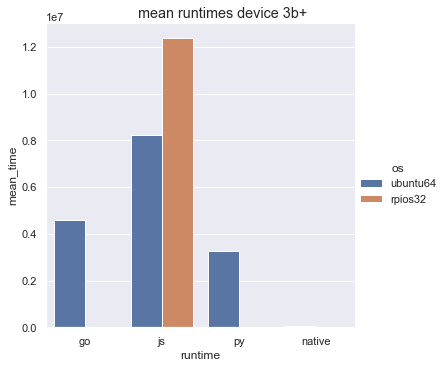

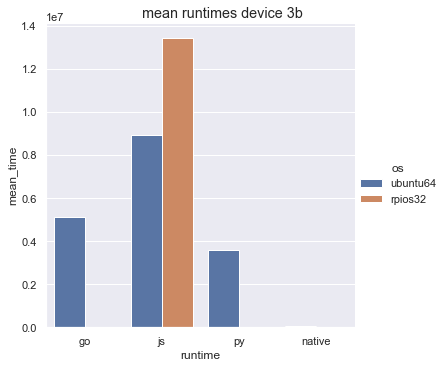

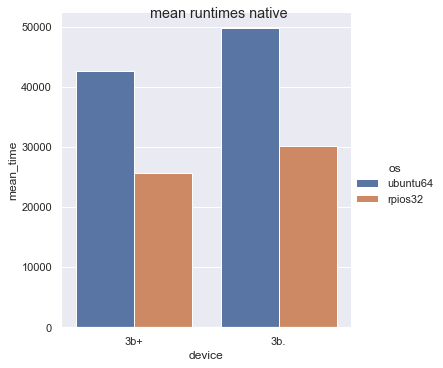

In [66]:
import seaborn as sns
data_list = []
map_data_pure(
    lambda date, device, os, runtime, all_data:
        data_list.append({'device': device, 'os': os, 'runtime': runtime, 'mean_time': date}), runtime_device_data_means)
data = pandas.DataFrame(data_list)
sns.set(rc={'figure.facecolor':'white'})

tmp = data[data['device'] == '3b+']
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes device 3b+')
ax.savefig("mean_times_3b+.png")

tmp = data[data['device'] == '3b.']
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes device 3b')
ax.savefig("mean_times_3b.png")

tmp = data.query("runtime=='native'")
ax = sns.catplot(data = tmp, kind="bar", x="device", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes native')
ax.savefig("mean_times_native.png")

## Data time standard deviations (ns)

In [67]:
time_field = 'time (ns)'
runtime_device_data_stds = map_data(lambda date, device, os, runtime, all_data: date[time_field].std())
pretty_print_data(runtime_device_data_stds, 'ms')

3b+:
	ubuntu64:
		go: 2.524160953178403 ms
		js: 5.81342464970086 ms
		py: 1.4528913005266697 ms
		native: 0.014889705254302422 ms
	rpios32:
		js: 41.38579831069536 ms
		native: 0.03917422269880908 ms
3b.:
	ubuntu64:
		go: 2.845189445467819 ms
		js: 6.368635902409733 ms
		py: 1.5940647578133609 ms
		native: 0.0182328473309366 ms
	rpios32:
		js: 44.775194575832884 ms
		native: 0.044768709584698134 ms


In [68]:
# time.apply(lambda date: date/1000000).max()

,device,variant,os,runtime,mean time relative to native
0,Raspberry Pi 3b+,with fs sys-call,Ubuntu,go,107.07
1,Raspberry Pi 3b+,with fs sys-call,Ubuntu,js,193.22
2,Raspberry Pi 3b+,with fs sys-call,Ubuntu,python,76.42
3,Raspberry Pi 3b+,with fs sys-call,Raspbian,js,481.37
4,Raspberry Pi 3b+,without fs sys-call,Ubuntu,go,7.58
5,Raspberry Pi 3b+,without fs sys-call,Ubuntu,js,148.20
6,Raspberry Pi 3b+,without fs sys-call,Ubuntu,python,53.98
7,Raspberry Pi 3b+,without fs sys-call,Raspbian,js,1363.93
8,Raspberry Pi 3b,with fs sys-call,Ubuntu,go,103.39
9,Raspberry Pi 3b,with fs sys-call,Ubuntu,js,179.80


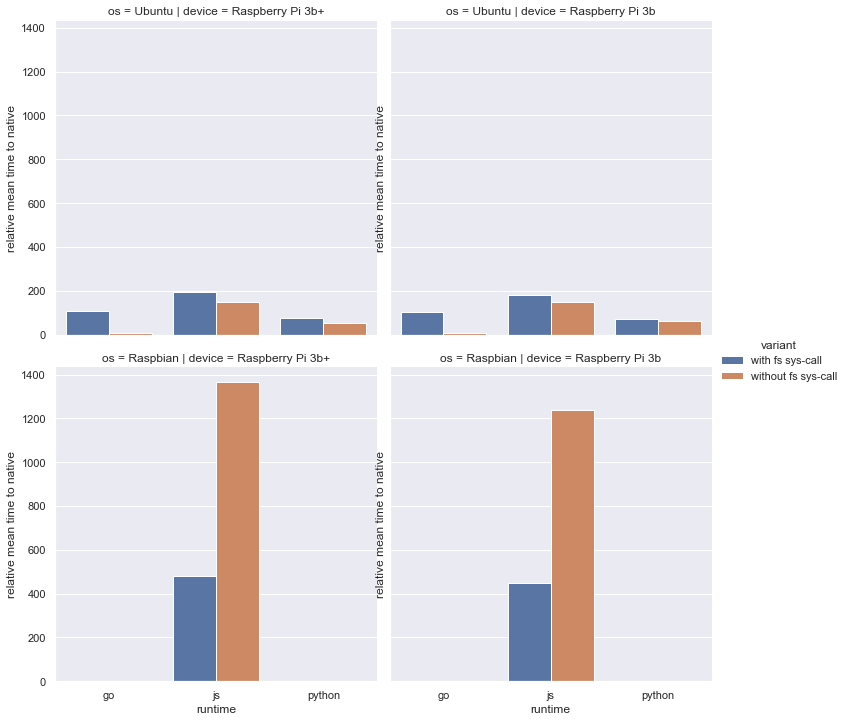

In [62]:
total_means_data = [
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'go', 107.07],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'js', 193.22],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'python', 76.42],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Raspbian', 'js', 481.37],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'go', 7.58],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'js', 148.20],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'python', 53.98],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Raspbian', 'js', 1363.93],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'go', 103.39],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'js', 179.80],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'python', 71.77],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Raspbian', 'js', 446.58],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'go', 7.64],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'js', 149.15],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'python', 59.48],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Raspbian', 'js', 1238.18],
]
total_means = pandas.DataFrame(total_means_data, columns=["device", "variant", "os", "runtime", "mean time relative to native"])
display(total_means)

import seaborn as sns

data_list = []
sns.set(rc={'figure.facecolor':'white'})
tmp = total_means
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean time relative to native", hue="variant", col="device", row="os")
ax.set(ylabel='relative mean time to native')
ax.savefig("relative_mean_times_3b+.png")